In [2]:
import matplotlib.pyplot as plt
import pandas_datareader as web
import numpy as np
import pandas as pd
from yahoofinancials import YahooFinancials
import plotly.graph_objects as go
import yfinance as yf
from stldecompose import decompose

/Users/taylanerdogan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = yf.download('THYAO.IS',start='2019-01-01',progress=False)
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,16.059999,16.129999,15.91,16.10,16.10,12553160
2019-01-01,16.100000,16.100000,16.10,16.10,16.10,0
2019-01-02,16.129999,16.250000,15.65,15.68,15.68,48650466
2019-01-03,15.610000,16.000000,15.09,15.15,15.15,60474927
2019-01-04,15.350000,15.450000,14.82,15.09,15.09,51431175
...,...,...,...,...,...,...
2020-12-31,12.910000,13.090000,12.88,13.02,13.02,56720032
2021-01-04,12.970000,12.970000,12.67,12.68,12.68,59948726
2021-01-05,12.640000,12.800000,12.52,12.58,12.58,90905126


In [4]:
close_app = df.iloc[len(df)//2:,3]
close_app

Date
2019-12-26    13.96
2019-12-27    13.96
2019-12-30    14.30
2019-12-31    14.46
2020-01-02    14.83
              ...  
2020-12-31    13.02
2021-01-04    12.68
2021-01-05    12.58
2021-01-06    12.68
2021-01-07    12.70
Name: Close, Length: 258, dtype: float64

In [5]:
rolling_app5 = close_app.rolling(window=5).mean()
rolling_app14 = close_app.rolling(window=13).mean()
rolling_app21 = close_app.rolling(window=21).mean()

In [6]:
MAs = pd.concat([close_app,rolling_app5,rolling_app14,rolling_app21],axis=1)

In [7]:
MAs.columns = ['Close','short','mid','long']
MAs.dropna(axis=0,inplace=True)
MAs.head(30)

,Close,short,mid,long
Date,,,,
2020-01-24,14.54,14.698,14.620769,14.426667
2020-01-27,14.10,14.502,14.666923,14.433333
2020-01-28,14.16,14.364,14.659231,14.442857
2020-01-29,14.11,14.234,14.637692,14.433810
2020-01-30,13.79,14.140,14.557692,14.401905
2020-01-31,13.70,13.972,14.471539,14.348095
2020-02-03,13.83,13.918,14.403077,14.327143
2020-02-04,14.34,13.954,14.349231,14.363810
2020-02-05,14.61,14.054,14.317692,14.414762


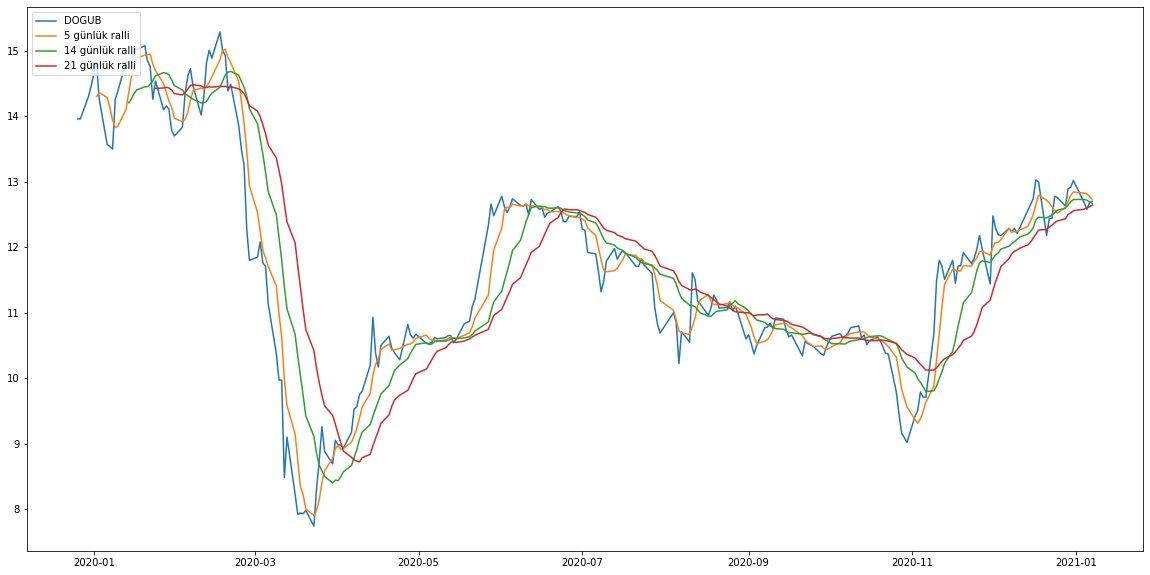

In [8]:
fig,ax = plt.subplots(figsize =(20,10))
ax.plot(close_app.index,close_app,label='DOGUB')
ax.plot(rolling_app5.index,rolling_app5,label='5 günlük ralli')
ax.plot(rolling_app14.index,rolling_app14,label='14 günlük ralli')
ax.plot(rolling_app21.index,rolling_app21,label='21 günlük ralli')
ax.legend(loc= 'upper left')

In [9]:
def buy_sell_MA(data,opt):
    buy_signal = []
    sell_signal = []
    buy_sell = []
    flag = 42
    
    up = data[(np.array(data['short']-data['mid'])>0 )& (np.array(data['short']- data['long'])>0)]
    down = data[(np.array(data['short']-data['mid'])<0) & (np.array(data['short']- data['long'])<0)]
    ups = np.percentile(np.array(up['short']-up['mid']),opt)
    downs = np.percentile(np.array(up['short']-up['long']),opt)
    
    for i in range(0,len(data)):
        if (data['short'][i]>data['mid'][i]+ups) & (data['short'][i]> data['long'][i]+ups):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(data['Close'][i])
                buy_sell.append(data['Close'][i])
                flag =1
            else:
                sell_signal.append(np.nan)
        elif (data['short'][i]<data['mid'][i]+downs) & (data['short'][i]< data['long'][i]+downs):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(data['Close'][i])
                buy_sell.append(-data['Close'][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            buy_sell.append(np.nan)
            
             
        operations = np.array(buy_sell)
        operations = operations[~np.isnan(operations)]
        pos = 0
        neg= 0
        for i in range(len(operations)):
            if operations[i] < 0 :
                neg = i
                break
        for i in range(1,len(operations)):
            if operations[-i] > 0:
                pos = i - 1
                break
        operations = operations[neg:-pos]
        PL = np.sum(operations)
    return (buy_signal,sell_signal,PL)
    
    

In [10]:
opt=[]
percentille = np.arange(10,91,5)
for i,j in enumerate(percentille):
    opt.append((percentille[i],buy_sell_MA(MAs,j)[2]))
opt 

[(10, 0.0),
 (15, -3.939999580383301),
 (20, -4.289999961853027),
 (25, -4.219999313354492),
 (30, -4.479999542236328),
 (35, -4.1399993896484375),
 (40, -3.9600000381469727),
 (45, -4.180000305175781),
 (50, -3.6399993896484375),
 (55, -2.2100000381469727),
 (60, -2.440000534057617),
 (65, -2.4600000381469727),
 (70, -2.8299999237060547),
 (75, -3.030000686645508),
 (80, -2.359999656677246),
 (85, -3.060000419616699),
 (90, -2.9900007247924805)]

In [11]:
MAs['BUY'] = buy_sell_MA(MAs,opt['Percentille'].values[0])[0]
MAs['SELL'] = buy_sell_MA(MAs,opt['Percentille'].values[0])[1]
MAs['BUY']

TypeError: list indices must be integers or slices, not str

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(MAs.index,MAs['BUY'],color='green',label='BUY',marker='*',alpha=1)
plt.scatter(MAs.index,MAs['SELL'],color='red',label='SELL',marker='v',alpha=1)
plt.plot(MAs['Close'],label='Kapanış Fiyatı',alpha=0.5)
plt.title('Kapanış fiyatı ve Al-Sat Sinyalleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc = 'upper left')
plt.show()

KeyError: 'BUY'

<Figure size 1440x720 with 0 Axes>

In [ ]:
BBs = pd.DataFrame()

In [ ]:
BBs['close'] = MAs['Close']
BBs['SMA'] = MAs['Close'].rolling(window=20).mean()
BBs['STD'] = MAs['Close'].rolling(window=20).std()
BBs['upper'] = BBs['SMA'] + BBs['STD'] *2
BBs['lower'] = BBs['SMA'] - BBs['STD'] *2
BBs.dropna(axis = 0 , inplace = True)
BBs.head()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
x_axis = BBs.index
ax.fill_between(x_axis,BBs['upper'],BBs['lower'],color='grey',alpha=0.5)
ax.plot(x_axis,BBs['close'],label='Kapanış')
ax.plot(x_axis,BBs['SMA'],label='Simple Moving Average',lw=3)
ax.legend()


In [ ]:
def buy_sell_BB(data):
    buy_signal = []
    sell_signal=[]
    buy_sell=[]
    flag = 42
    for i in range(0,len(data)):
        if data['close'][i] > data['upper'][i]:
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(data['close'][i])
                buy_sell.append(data['close'][i])
                flag =1 
            else:
                sell_signal.append(np.nan)
        elif data['close'][i] < data['lower'][i]:
            sell_signal.append(np.nan)
            if flag != 0 :
                buy_signal.append(data['close'][i])
                buy_sell.append(data['close'][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            buy_sell.append(np.nan)
            
        operations = np.array(buy_sell)
        operations = operations[~np.isnan(operations)]
        pos = 0
        neg= 0
        for i in range(len(operations)):
             if operations[i] < 0 :
                    neg = i
                    break
        for i in range(1,len(operations)):
             if operations[-i] > 0:
                    pos = i - 1
                    break
        operations = operations[neg:-pos]
        PL = np.sum(operations)
        return (buy_signal,sell_signal,PL)

In [ ]:
BBs['BUY'] = buy_sell_BB(BBs)[0]
BBs